In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
fn = 'data/1.txt'
data = pd.read_csv(fn, sep='\t')
data = data[['Secondi', 'Canale_1', 'Canale_2', 'Canale_4', 'Canale_5', 'Canale_6', 'Canale_7', 'Canale_8', 'RH%']].copy()
data.head()

,Secondi,Canale_1,Canale_2,Canale_4,Canale_5,Canale_6,Canale_7,Canale_8,RH%
0,5,0.315,0.678,5.529,5.064,0.614,5.185,5.969,2.413
1,10,0.314,0.677,5.529,5.042,0.614,5.185,5.969,2.407
2,15,0.314,0.677,5.529,5.059,0.613,5.185,5.969,2.425
3,20,0.314,0.677,5.529,5.069,0.613,5.184,5.969,2.409
4,25,0.314,0.676,5.529,5.085,0.612,5.185,5.969,2.433


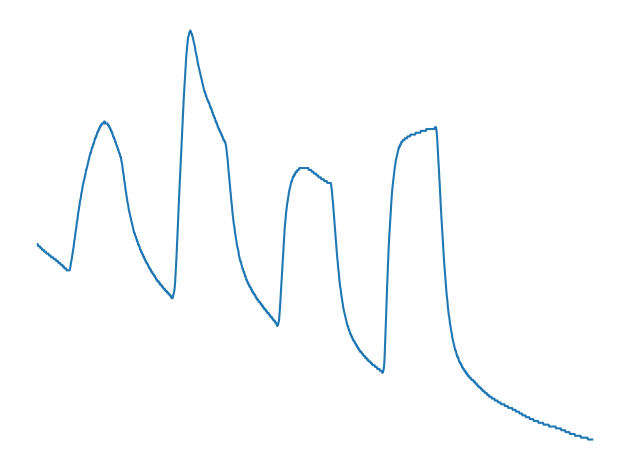

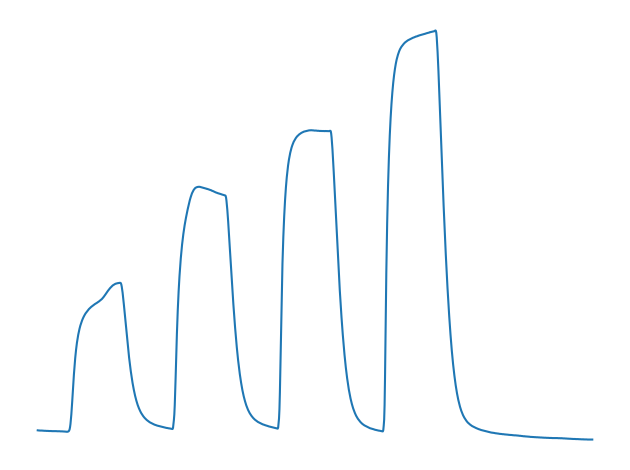

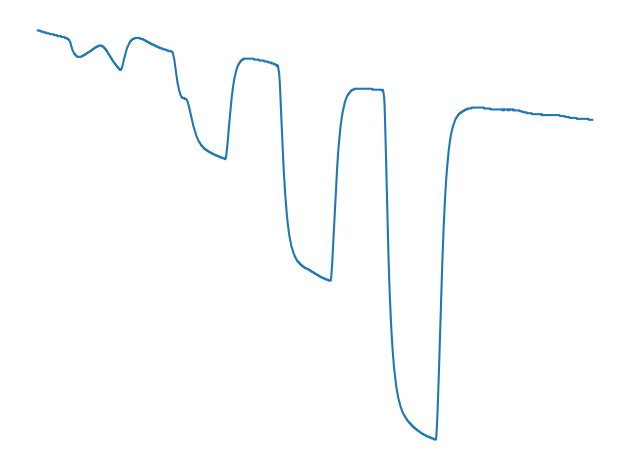

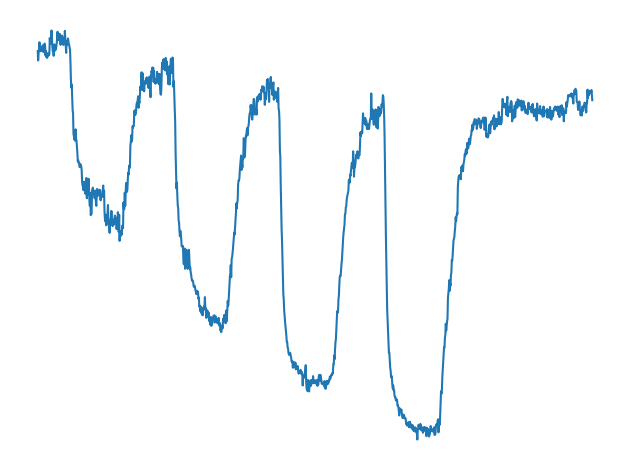

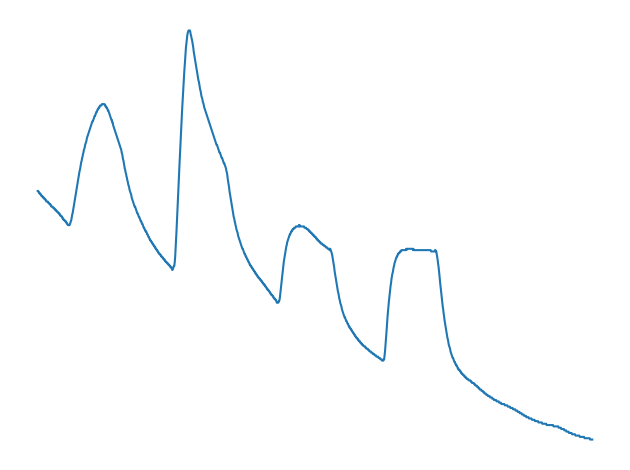

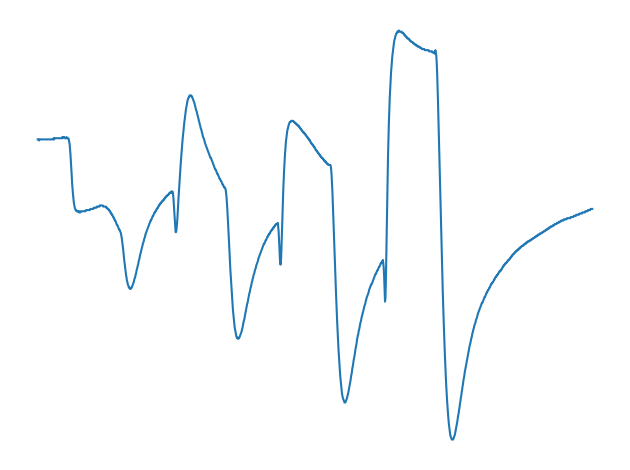

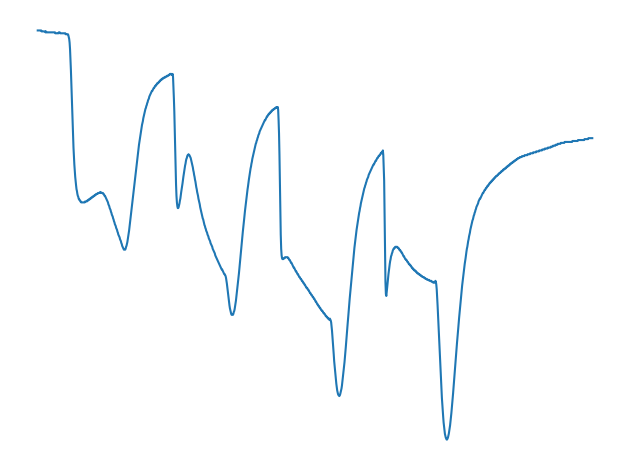

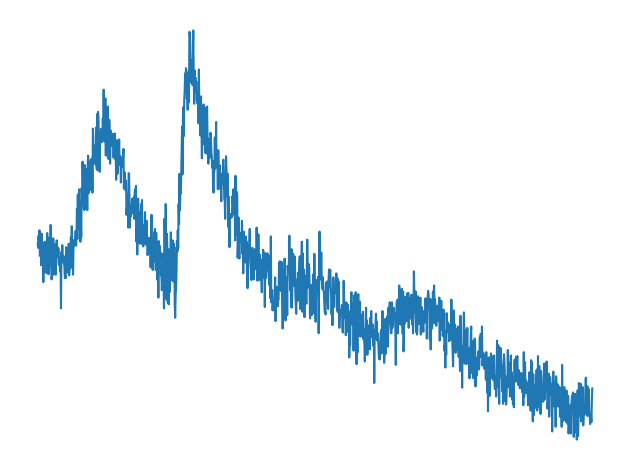

In [10]:
x = data['Secondi']
j = 0
for i, c in enumerate(['Canale_1', 'Canale_2', 'Canale_4', 'Canale_5', 'Canale_6', 'Canale_7', 'Canale_8', 'RH%']):
    y = data[c]
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'{j}.png', bbox_inches='tight', pad_inches=0)
    j += 1



In [13]:
import os
os.listdir('data')

['9.txt',
 '21.txt',
 '20.txt',
 '8.txt',
 '15.txt',
 '16.txt',
 '11.txt',
 '3.txt',
 '18.txt',
 '7.txt',
 '2.txt',
 '6.txt',
 '5.txt',
 '14.txt',
 '10.txt',
 '12.txt',
 '22.txt',
 '13.txt',
 '23.txt',
 '24.txt',
 '17.txt',
 '1.txt',
 '4.txt',
 '19.txt']